## Лабортаторная работа №7

### По курсу "нейроинформатика"

студент: Гаврилов М.С.  
группа: М8О-406Б-19  

##### Цель работы:
Исследование свойств автоэнкодеров

In [1]:
import numpy as np
import pylab
import copy
import sklearn as skl

import torch
import torch.nn as nn
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

#### Загрузка cifar-10 и формирование датасета из одного класса

In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def normalize(img):
    res = copy.deepcopy(img)
    for i in range(len(img)):
        res[i] = img[i] / img[i].abs().max()
    return res

def print_imgs(dataloader,cnt,net = None):
    imgs = next(iter(dataloader))
    imshow(torchvision.utils.make_grid(
        normalize(imgs.reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:cnt].detach())
    ))
    
    if(net != None):
        imshow(torchvision.utils.make_grid(
            normalize(net(imgs).reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:cnt].detach())
        ))

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifarset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
cifarloader = torch.utils.data.DataLoader(cifarset, batch_size=1,
                                          shuffle=True, num_workers=2)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [5]:
class_to_extract = 7

single_class_set = []
for data,label in tqdm(cifarloader):
    if label[0] == class_to_extract:
        single_class_set.append(data)
sc_loader = torch.utils.data.DataLoader(single_class_set, batch_size=64,
                                          shuffle=True, num_workers=2)        

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [01:10<00:00, 706.68it/s]


Пример изображений выбранного класса

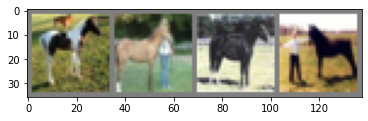

In [252]:
print_imgs(sc_loader,4)

#### Класс автоэнкодера

Две ступени, латентне пространство размером 512

In [82]:
class Autoencoder(torch.nn.Module):
    def __init__(self,linear_size):
        super(Autoencoder,self).__init__()
        
        self.EDN = torch.nn.Sequential(
        torch.nn.Linear(linear_size,1024),
        #torch.nn.ReLU(),
        torch.nn.Linear(1024,512),
        torch.nn.Linear(512,1024),
        #torch.nn.ReLU(),
        torch.nn.Linear(1024,linear_size))
        
    def forward(self,x):
        im_shape = x.shape
        x = x.flatten(1)
        res = self.EDN(x).reshape(im_shape)
        return res

Функия оучения

In [83]:
def train(model,dataloader,n_epochs,lr,
         optimiser = torch.optim.Adam,
         criterion = torch.nn.MSELoss()
         ):
    
    optim = optimiser(model.parameters(),lr=lr)
    
    arr = []
    for i in tqdm(range(n_epochs)):
        for elm in dataloader:
            optim.zero_grad()            
            loss = ((model(elm) - elm)**2).sum()
            loss.backward()
            optim.step()

        arr.append([i,
                    loss.detach().numpy(),
                   ])

    return np.array(arr)

Построение и обучение первой сети

In [84]:
tst_net = Autoencoder(single_class_set[0].flatten().shape[0])

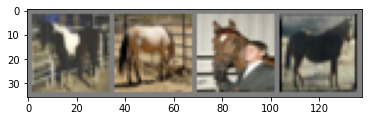

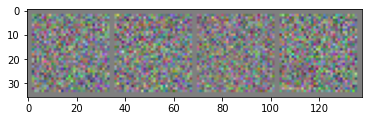

In [85]:
print_imgs(sc_loader,4,tst_net)

In [86]:
arr = train(tst_net,sc_loader,100,0.01)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [33:49<00:00, 20.30s/it]


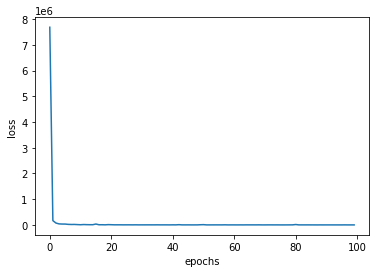

In [87]:
pylab.ylabel("loss")
pylab.xlabel("epochs")
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

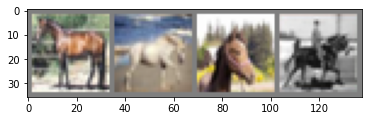

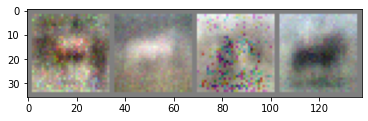

In [88]:
print_imgs(sc_loader,4,tst_net)

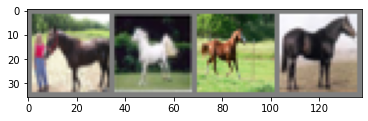

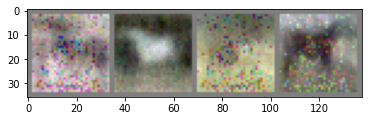

In [90]:
print_imgs(sc_loader,4,tst_net)

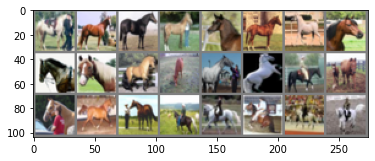

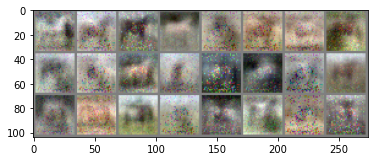

In [89]:
print_imgs(sc_loader,24,tst_net)

### Более простой автоэнкодер

In [8]:
class Autoencoder(torch.nn.Module):
    def __init__(self,linear_size):
        super(Autoencoder,self).__init__()
        
        self.EDN = torch.nn.Sequential(
        torch.nn.Linear(linear_size,1024),
        torch.nn.Linear(1024,linear_size))
        
    def forward(self,x):
        im_shape = x.shape
        x = x.flatten(1)
        res = self.EDN(x).reshape(im_shape)
        return res

In [9]:
repl_net = Autoencoder(single_class_set[0].flatten().shape[0])

In [13]:
arr = train(repl_net,sc_loader,50,0.01)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [11:34<00:00, 13.89s/it]


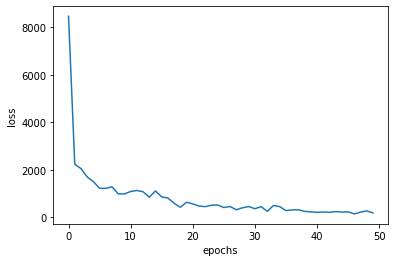

In [14]:
pylab.ylabel("loss")
pylab.xlabel("epochs")
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

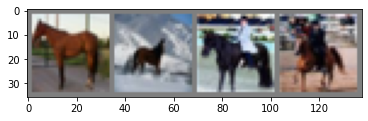

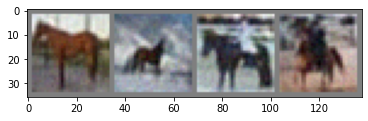

In [15]:
print_imgs(sc_loader,4,repl_net)

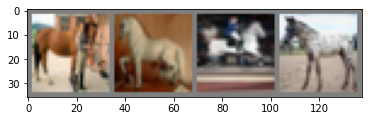

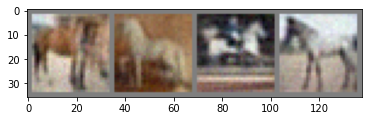

In [16]:
print_imgs(sc_loader,4,repl_net)

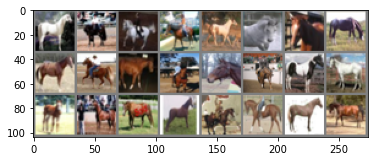

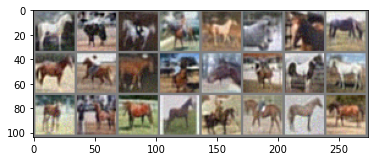

In [17]:
print_imgs(sc_loader,24,repl_net)

### Примеры интересных результатов

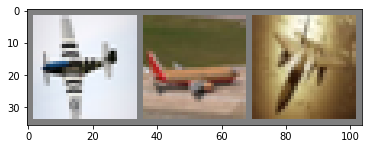

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


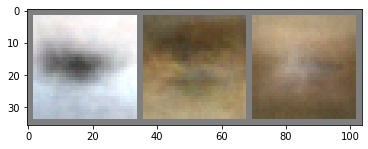

In [145]:
imgs = next(iter(scd_loader))
imshow(torchvision.utils.make_grid(
    imgs.reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3]
).detach())
imshow(torchvision.utils.make_grid(
    tst_net(imgs).reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3]
).detach())

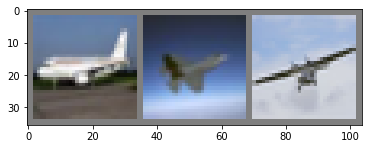

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


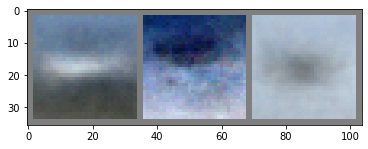

In [148]:
imgs = next(iter(scd_loader))
imshow(torchvision.utils.make_grid(
    imgs.reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3]
).detach())
imshow(torchvision.utils.make_grid(
    tst_net(imgs).reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3]
).detach())

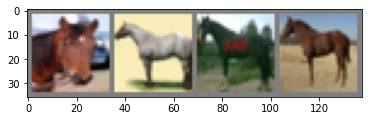

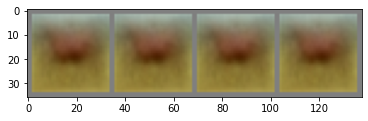

In [80]:
print_imgs(sc_loader,4,tst_net)

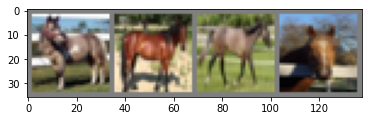

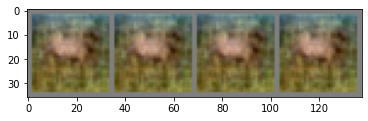

In [69]:
print_imgs(sc_loader,4,tst_net)

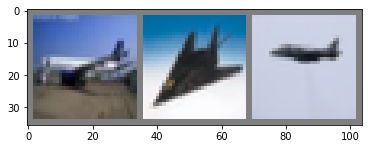

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


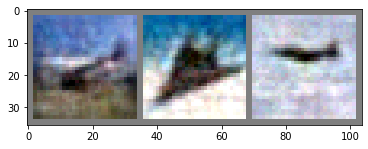

In [159]:
imgs = next(iter(scd_loader))
imshow(torchvision.utils.make_grid(
    imgs.reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3]
).detach())
imshow(torchvision.utils.make_grid(
    repl_net(imgs).reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3]
).detach())

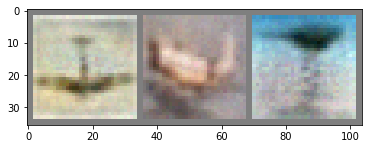

In [197]:
imshow(torchvision.utils.make_grid(normalize(repl_net(imgs).reshape([imgs.shape[0]] + list(imgs.shape[2:]))[0:3].detach())))

### Вывод
В ходе выполнения этой лабораторной работы я ознакомился с принипами работы автоэнкодера и получил опыт в реализации простых автоэнкодеров. К сожалению, во время выполнения этой работы у меня не было доступа к cuda, и я не смог обучить более сложные сети